# Phase Space Analysis of Algorithmic Stablecoins

This notebook visualizes the system dynamics in phase space to identify:

- **Attractors**: Stable equilibrium points
- **Repellers**: Unstable equilibrium points  
- **Trajectories**: System evolution under stress
- **Critical regions**: Areas of instability

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '..')

from model import SystemParameters, simulate_step
from experiments import run_collateral_shock_experiment, run_liquidity_crisis_experiment

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

## 1. Generate Trajectories for Phase Space

We run multiple simulations with different initial conditions and shock parameters.

In [16]:
# Base parameters
params = SystemParameters(random_seed=42)

# Generate trajectories with different shock magnitudes
trajectories = []
shock_values = [-0.1, -0.2, -0.3, -0.4, -0.5]

for shock in shock_values:
    result = run_collateral_shock_experiment(
        shock_magnitude=shock,
        shock_time=100,
        params=params,
        n_steps=500
    )
    trajectories.append({
        'shock': shock,
        'price': result.price,
        'supply': result.supply,
        'liquidity': result.liquidity,
        'demand': result.demand
    })

print(f"Generated {len(trajectories)} trajectories")

Generated 5 trajectories


## 2. 2D Phase Space: Price vs Supply

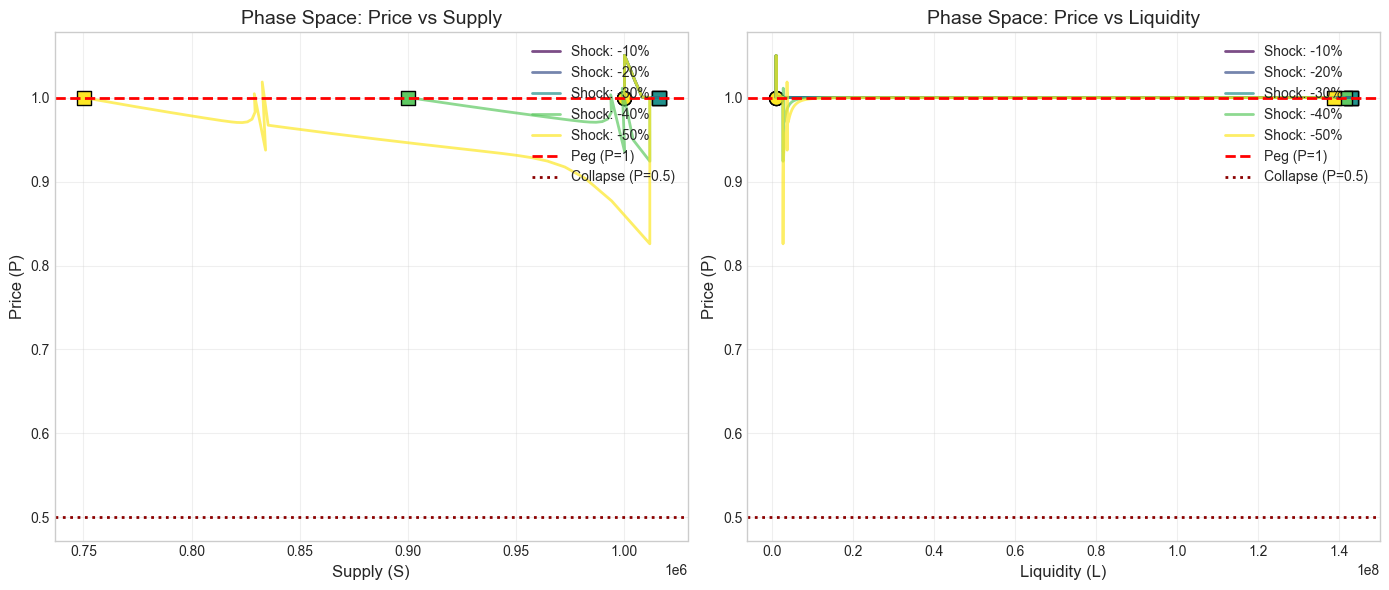

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Price vs Supply
colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories)))
for i, traj in enumerate(trajectories):
    axes[0].plot(traj['supply'], traj['price'], 
                 color=colors[i], 
                 label=f"Shock: {traj['shock']:.0%}",
                 linewidth=2, alpha=0.7)
    # Mark starting point
    axes[0].scatter(traj['supply'][0], traj['price'][0], 
                    color=colors[i], s=100, marker='o', edgecolors='black')
    # Mark ending point
    axes[0].scatter(traj['supply'][-1], traj['price'][-1], 
                    color=colors[i], s=100, marker='s', edgecolors='black')

# Mark equilibrium
axes[0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Peg (P=1)')
axes[0].axhline(y=0.5, color='darkred', linestyle=':', linewidth=2, label='Collapse (P=0.5)')

axes[0].set_xlabel('Supply (S)', fontsize=12)
axes[0].set_ylabel('Price (P)', fontsize=12)
axes[0].set_title('Phase Space: Price vs Supply', fontsize=14)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Price vs Liquidity
for i, traj in enumerate(trajectories):
    axes[1].plot(traj['liquidity'], traj['price'], 
                 color=colors[i], 
                 label=f"Shock: {traj['shock']:.0%}",
                 linewidth=2, alpha=0.7)
    axes[1].scatter(traj['liquidity'][0], traj['price'][0], 
                    color=colors[i], s=100, marker='o', edgecolors='black')
    axes[1].scatter(traj['liquidity'][-1], traj['price'][-1], 
                    color=colors[i], s=100, marker='s', edgecolors='black')

axes[1].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Peg (P=1)')
axes[1].axhline(y=0.5, color='darkred', linestyle=':', linewidth=2, label='Collapse (P=0.5)')

axes[1].set_xlabel('Liquidity (L)', fontsize=12)
axes[1].set_ylabel('Price (P)', fontsize=12)
axes[1].set_title('Phase Space: Price vs Liquidity', fontsize=14)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/phase_space_2d.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. 3D Phase Space: Price, Supply, Liquidity

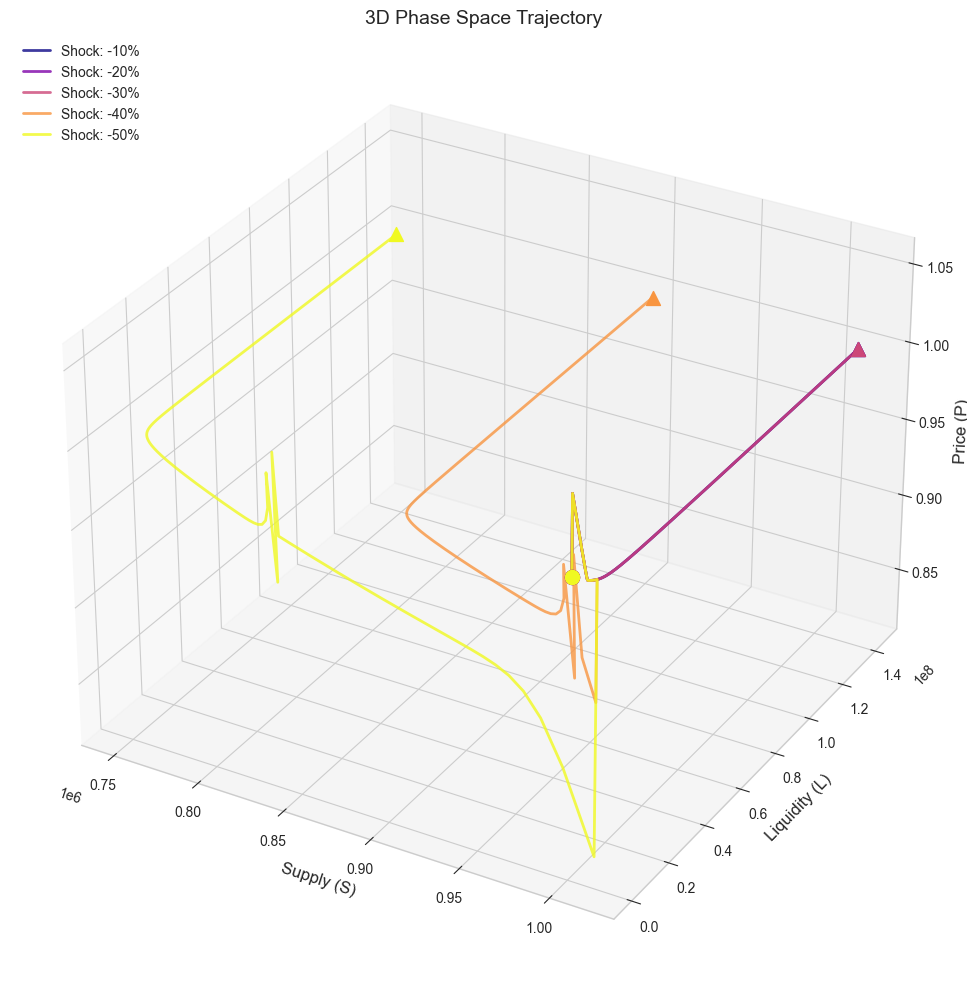

In [18]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.plasma(np.linspace(0, 1, len(trajectories)))

for i, traj in enumerate(trajectories):
    ax.plot3D(traj['supply'], traj['liquidity'], traj['price'],
              color=colors[i], linewidth=2, alpha=0.8,
              label=f"Shock: {traj['shock']:.0%}")
    
    # Mark start and end
    ax.scatter3D(traj['supply'][0], traj['liquidity'][0], traj['price'][0],
                 color=colors[i], s=100, marker='o')
    ax.scatter3D(traj['supply'][-1], traj['liquidity'][-1], traj['price'][-1],
                 color=colors[i], s=100, marker='^')

ax.set_xlabel('Supply (S)', fontsize=12)
ax.set_ylabel('Liquidity (L)', fontsize=12)
ax.set_zlabel('Price (P)', fontsize=12)
ax.set_title('3D Phase Space Trajectory', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('../results/plots/phase_space_3d.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Vector Field Visualization

Visualize the direction of system evolution at different points in state space.

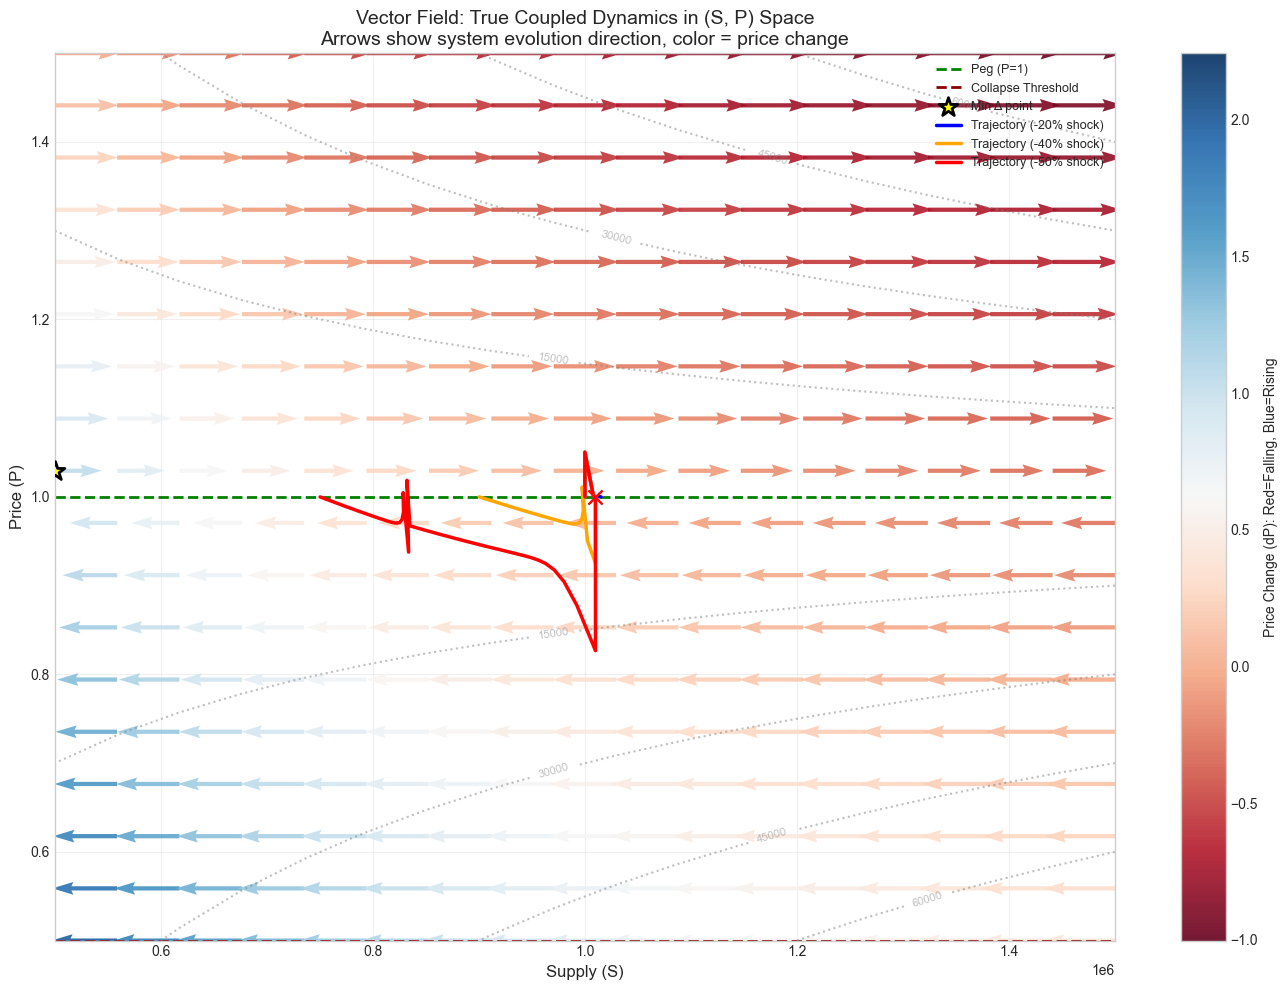


Vector field statistics:
  Max |dS|: 75000
  Max |dP|: 2.2444
  Equilibrium region near S=500000, P=1.03


In [19]:
# Create grid for vector field - TRUE COUPLED DYNAMICS
# Key insight: We need to evolve ALL state variables together, not freeze them

S_range = np.linspace(5e5, 1.5e6, 18)
P_range = np.linspace(0.5, 1.5, 18)
S_grid, P_grid = np.meshgrid(S_range, P_range)

# Compute derivatives at each point with COUPLED dynamics
dS = np.zeros_like(S_grid)
dP = np.zeros_like(P_grid)

params = SystemParameters()

# Import the individual update functions for computing true gradients
from model.dynamics import update_supply, update_price, update_demand, update_liquidity

for i in range(S_grid.shape[0]):
    for j in range(S_grid.shape[1]):
        S = S_grid[i, j]
        P = P_grid[i, j]
        
        # Compute state-dependent values (not frozen!)
        # Liquidity depends on price stability
        L = params.initial_liquidity * (1.0 - 0.5 * abs(P - 1.0))
        L = max(L, params.liquidity_depth * 0.1)
        
        # Demand depends on price (elastic)
        D = params.initial_demand * (1.0 - params.demand_elasticity * (P - 1.0))
        D = max(D, params.initial_demand * 0.1)
        
        # Collateral ratio matters for solvency
        C = params.initial_collateral * (S / params.initial_supply)  # Scales with supply
        
        # Compute TRUE derivatives using actual model functions
        S_new = update_supply(S, P, L, params)
        P_new = update_price(S_new, D, L, C, params)
        
        dS[i, j] = S_new - S
        dP[i, j] = P_new - P

# Scale for visibility (log-scale magnitudes)
magnitude = np.sqrt(dS**2 + dP**2)
max_mag = np.percentile(magnitude, 95)  # Avoid outliers
magnitude_clipped = np.clip(magnitude, 0, max_mag)

# Normalize for arrow visibility but keep direction
arrow_scale = np.log1p(magnitude) / (np.log1p(max_mag) + 1e-6)
dS_norm = dS / (magnitude + 1e-6) * arrow_scale
dP_norm = dP / (magnitude + 1e-6) * arrow_scale

# Plot vector field with REAL dynamics
fig, ax = plt.subplots(figsize=(14, 10))

# Color by dP (price change direction) - red = falling, blue = rising
quiver = ax.quiver(S_grid, P_grid, dS_norm, dP_norm, dP,
                   cmap='RdBu', alpha=0.9, scale=15, width=0.004)
plt.colorbar(quiver, label='Price Change (dP): Red=Falling, Blue=Rising')

# Mark key regions
ax.axhline(y=1.0, color='green', linestyle='--', linewidth=2, label='Peg (P=1)')
ax.axhline(y=0.5, color='darkred', linestyle='--', linewidth=2, label='Collapse Threshold')

# Mark equilibrium point
eq_idx = np.unravel_index(np.argmin(magnitude), magnitude.shape)
ax.scatter(S_grid[eq_idx], P_grid[eq_idx], s=200, c='yellow', edgecolors='black', 
           linewidth=2, marker='*', zorder=10, label=f'Min Δ point')

# Add contour lines for magnitude (shows force strength)
contour = ax.contour(S_grid, P_grid, magnitude, levels=5, colors='gray', alpha=0.5, linestyles=':')
ax.clabel(contour, inline=True, fontsize=8, fmt='%.0f')

# Overlay multiple trajectories with different shocks
for shock, color, ls in [(-0.2, 'blue', '-'), (-0.4, 'orange', '-'), (-0.5, 'red', '-')]:
    result = run_collateral_shock_experiment(
        shock_magnitude=shock,
        shock_time=50,
        params=params,
        n_steps=300
    )
    ax.plot(result.supply, result.price, color=color, linewidth=2.5, 
            linestyle=ls, label=f'Trajectory ({shock:.0%} shock)')
    ax.scatter(result.supply[50], result.price[50], s=100, c=color, marker='x', zorder=5)

ax.set_xlabel('Supply (S)', fontsize=12)
ax.set_ylabel('Price (P)', fontsize=12)
ax.set_title('Vector Field: True Coupled Dynamics in (S, P) Space\nArrows show system evolution direction, color = price change', fontsize=14)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(S_range[0], S_range[-1])
ax.set_ylim(P_range[0], P_range[-1])

plt.tight_layout()
plt.savefig('../results/plots/vector_field.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVector field statistics:")
print(f"  Max |dS|: {np.max(np.abs(dS)):.0f}")
print(f"  Max |dP|: {np.max(np.abs(dP)):.4f}")
print(f"  Equilibrium region near S={S_grid[eq_idx]:.0f}, P={P_grid[eq_idx]:.2f}")

## 5. Multi-Metric Stability Analysis

Instead of binary collapse detection, we analyze **continuous stress metrics** across the parameter space:

1. **Minimum Price**: Lowest price reached during simulation (direct collapse indicator)
2. **Maximum Drawdown**: Largest drop from peg (severity measure)
3. **Peg Deviation Integral**: Cumulative stress over time (∫|P-1|dt)
4. **Recovery Time**: Time to return within 5% of peg (resilience measure)

This gives a richer picture of system behavior across different liquidity and shock conditions.

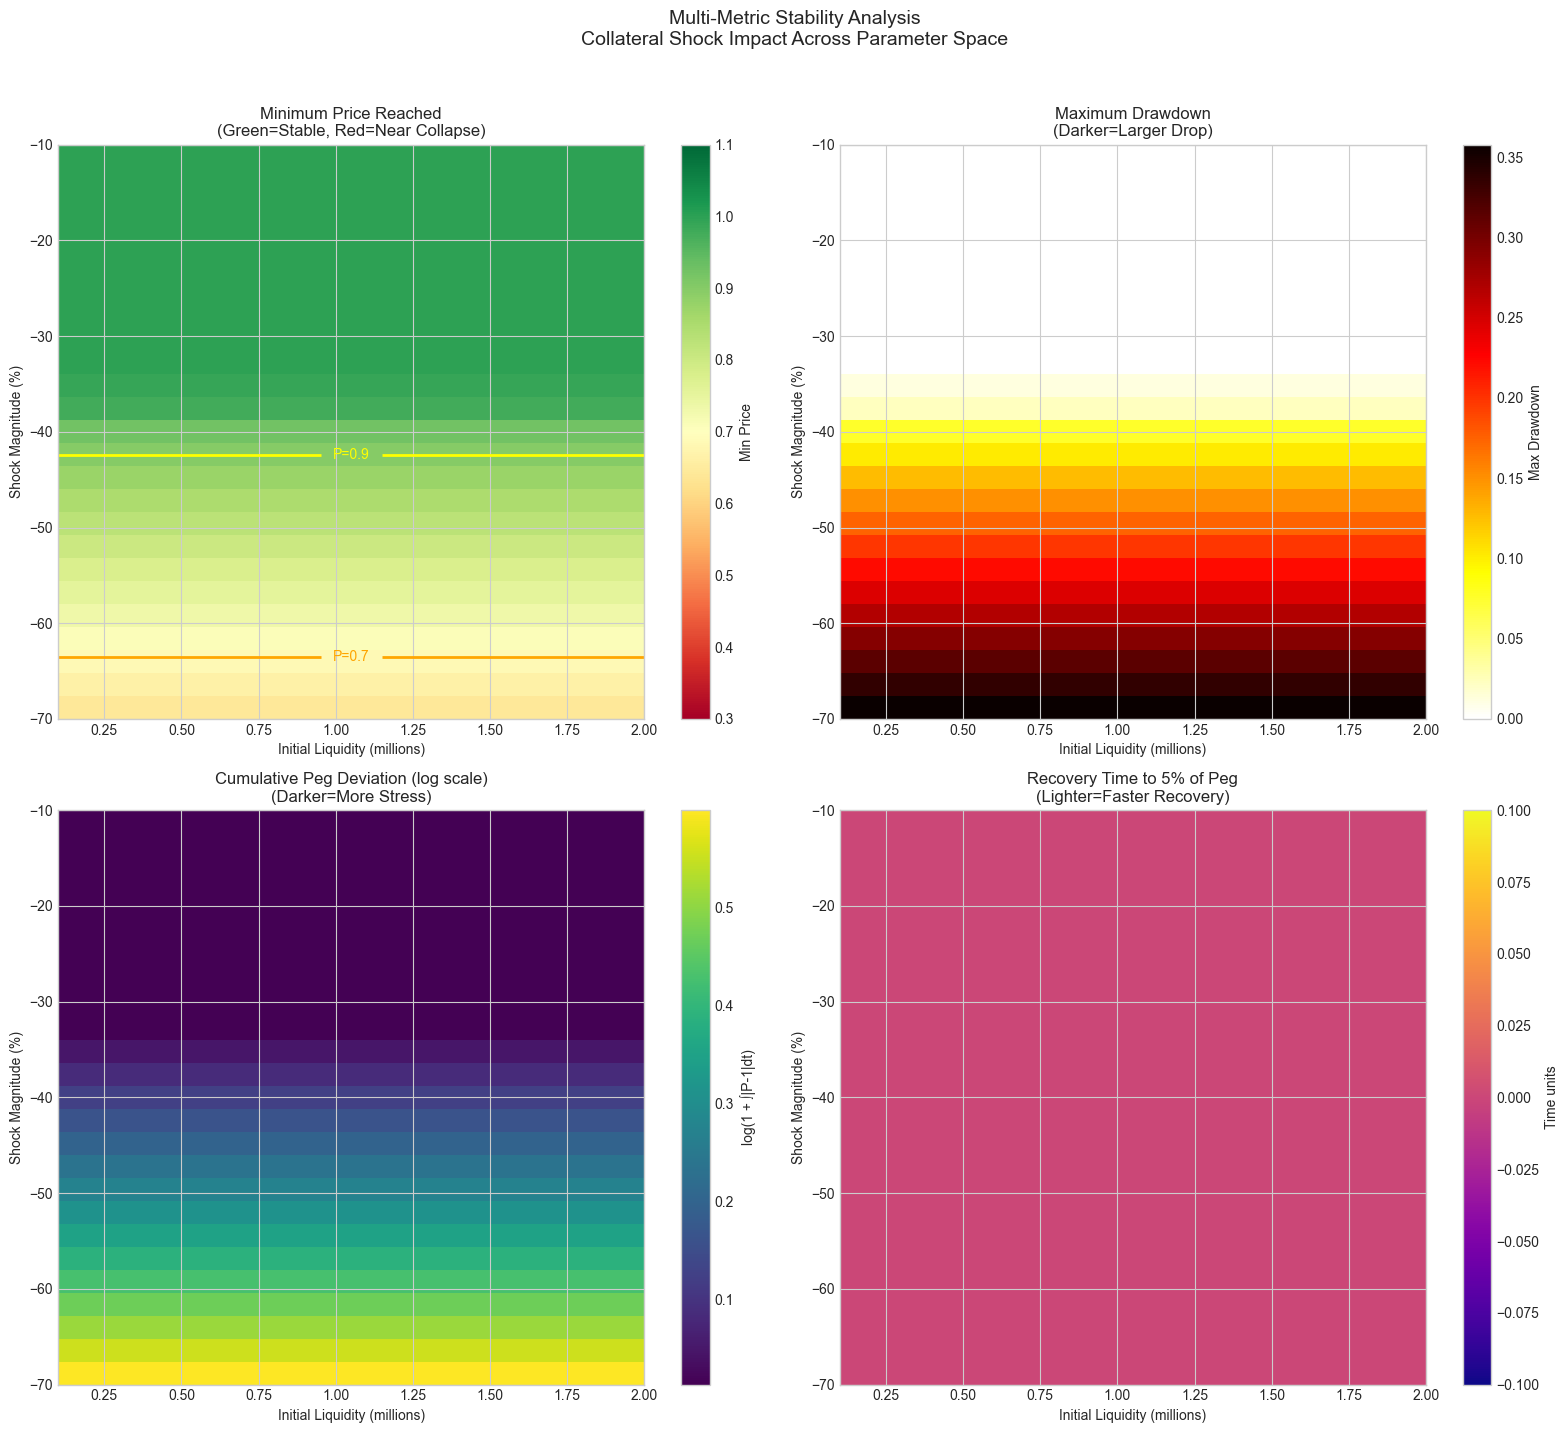


STABILITY ANALYSIS SUMMARY

Parameter space tested:
  Liquidity: 0.1M to 2.0M
  Shocks: -70% to -10%

Minimum price statistics:
  Lowest min price: 0.642
  Highest min price: 1.000
  % of space with min_price < 0.7: 12.0%
  % of space with min_price < 0.5: 0.0%

Recovery statistics:
  % of space that recovers: 100.0%
  Mean recovery time (when recovered): 0.0 time units


In [20]:
# CONTINUOUS STABILITY ANALYSIS
# Instead of binary collapse, measure STRESS METRICS across parameter space

liquidity_range = np.linspace(1e5, 2e6, 25)
shock_range = np.linspace(-0.7, -0.1, 25)

# Multiple metrics for richer analysis
min_price_map = np.zeros((len(shock_range), len(liquidity_range)))
max_drawdown_map = np.zeros((len(shock_range), len(liquidity_range)))
peg_deviation_map = np.zeros((len(shock_range), len(liquidity_range)))
recovery_time_map = np.zeros((len(shock_range), len(liquidity_range)))

for i, shock in enumerate(shock_range):
    for j, liq in enumerate(liquidity_range):
        test_params = SystemParameters(
            initial_liquidity=liq,
            liquidity_depth=liq * 0.5  # Dynamic liquidity depth
        )
        result = run_collateral_shock_experiment(
            shock_magnitude=shock,
            shock_time=50,
            params=test_params,
            n_steps=500
        )
        
        # Minimum price reached (lower = worse)
        min_price_map[i, j] = np.min(result.price)
        
        # Maximum drawdown from peg
        max_drawdown_map[i, j] = result.max_drawdown
        
        # Peg deviation integral (cumulative stress)
        peg_deviation_map[i, j] = result.peg_deviation_integral
        
        # Recovery time (time to get back within 5% of peg)
        post_shock = result.price[50:]
        recovered_mask = np.abs(post_shock - 1.0) < 0.05
        if np.any(recovered_mask):
            recovery_time_map[i, j] = np.argmax(recovered_mask) * test_params.dt
        else:
            recovery_time_map[i, j] = np.inf

# Create multi-panel stability visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

extent = [liquidity_range[0]/1e6, liquidity_range[-1]/1e6,
          shock_range[0]*100, shock_range[-1]*100]

# 1. Minimum Price (most direct collapse indicator)
im1 = axes[0, 0].imshow(min_price_map, aspect='auto', origin='lower',
                        extent=extent, cmap='RdYlGn', vmin=0.3, vmax=1.1)
axes[0, 0].set_title('Minimum Price Reached\n(Green=Stable, Red=Near Collapse)', fontsize=12)
axes[0, 0].set_xlabel('Initial Liquidity (millions)')
axes[0, 0].set_ylabel('Shock Magnitude (%)')
plt.colorbar(im1, ax=axes[0, 0], label='Min Price')
# Add contour for critical threshold
cs1 = axes[0, 0].contour(min_price_map, levels=[0.5, 0.7, 0.9], 
                         extent=extent, colors=['red', 'orange', 'yellow'], linewidths=2)
axes[0, 0].clabel(cs1, inline=True, fontsize=10, fmt='P=%.1f')

# 2. Max Drawdown 
im2 = axes[0, 1].imshow(max_drawdown_map, aspect='auto', origin='lower',
                        extent=extent, cmap='hot_r')
axes[0, 1].set_title('Maximum Drawdown\n(Darker=Larger Drop)', fontsize=12)
axes[0, 1].set_xlabel('Initial Liquidity (millions)')
axes[0, 1].set_ylabel('Shock Magnitude (%)')
plt.colorbar(im2, ax=axes[0, 1], label='Max Drawdown')

# 3. Peg Deviation Integral (cumulative stress)
# Log scale for better visualization
peg_dev_log = np.log1p(peg_deviation_map)
im3 = axes[1, 0].imshow(peg_dev_log, aspect='auto', origin='lower',
                        extent=extent, cmap='viridis')
axes[1, 0].set_title('Cumulative Peg Deviation (log scale)\n(Darker=More Stress)', fontsize=12)
axes[1, 0].set_xlabel('Initial Liquidity (millions)')
axes[1, 0].set_ylabel('Shock Magnitude (%)')
plt.colorbar(im3, ax=axes[1, 0], label='log(1 + ∫|P-1|dt)')

# 4. Recovery Time
recovery_clipped = np.clip(recovery_time_map, 0, 50)  # Cap at 50 for visualization
im4 = axes[1, 1].imshow(recovery_clipped, aspect='auto', origin='lower',
                        extent=extent, cmap='plasma')
axes[1, 1].set_title('Recovery Time to 5% of Peg\n(Lighter=Faster Recovery)', fontsize=12)
axes[1, 1].set_xlabel('Initial Liquidity (millions)')
axes[1, 1].set_ylabel('Shock Magnitude (%)')
cbar4 = plt.colorbar(im4, ax=axes[1, 1], label='Time units')
# Mark non-recovery regions
no_recovery = recovery_time_map == np.inf
if np.any(no_recovery):
    y_idx, x_idx = np.where(no_recovery)
    axes[1, 1].scatter(liquidity_range[x_idx]/1e6, shock_range[y_idx]*100, 
                       c='white', s=20, marker='x', label='No recovery')

plt.suptitle('Multi-Metric Stability Analysis\nCollateral Shock Impact Across Parameter Space', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../results/plots/stability_regions.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n" + "="*60)
print("STABILITY ANALYSIS SUMMARY")
print("="*60)
print(f"\nParameter space tested:")
print(f"  Liquidity: {liquidity_range[0]/1e6:.1f}M to {liquidity_range[-1]/1e6:.1f}M")
print(f"  Shocks: {shock_range[0]*100:.0f}% to {shock_range[-1]*100:.0f}%")

print(f"\nMinimum price statistics:")
print(f"  Lowest min price: {np.min(min_price_map):.3f}")
print(f"  Highest min price: {np.max(min_price_map):.3f}")
print(f"  % of space with min_price < 0.7: {100*np.mean(min_price_map < 0.7):.1f}%")
print(f"  % of space with min_price < 0.5: {100*np.mean(min_price_map < 0.5):.1f}%")

print(f"\nRecovery statistics:")
print(f"  % of space that recovers: {100*np.mean(recovery_time_map < np.inf):.1f}%")
print(f"  Mean recovery time (when recovered): {np.mean(recovery_time_map[recovery_time_map < np.inf]):.1f} time units")

# FEEDBACK LOOP ANALYSIS
# Measure how feedback effects amplify or dampen shocks

from model.dynamics import update_demand

def measure_feedback_strength(shock_mag, params, n_steps=200):
    """
    Measure feedback loop strength by comparing actual trajectory
    to a hypothetical no-feedback scenario.
    
    Returns: amplification factor (>1 means positive feedback amplifies shock)
    """
    # Run actual simulation
    result = run_collateral_shock_experiment(
        shock_magnitude=shock_mag,
        shock_time=50,
        params=params,
        n_steps=n_steps
    )
    
    # Direct shock impact (immediate price drop)
    direct_impact = abs(result.price[50] - result.price[49])
    
    # Total integrated impact
    post_shock_prices = result.price[50:]
    total_deviation = np.sum(np.abs(post_shock_prices - 1.0))
    
    # Amplification: ratio of total deviation to direct impact
    amplification = total_deviation / (direct_impact * len(post_shock_prices) + 1e-6)
    
    return amplification, result

# Test feedback across shock magnitudes
params = SystemParameters()
shock_tests = np.linspace(-0.1, -0.6, 15)
amplifications = []
trajectories = []

for shock in shock_tests:
    amp, result = measure_feedback_strength(shock, params)
    amplifications.append(amp)
    trajectories.append(result)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feedback amplification vs shock magnitude
axes[0, 0].plot(shock_tests * 100, amplifications, 'b-o', linewidth=2, markersize=8)
axes[0, 0].axhline(y=1.0, color='gray', linestyle='--', label='No amplification')
axes[0, 0].fill_between(shock_tests * 100, 1, amplifications, 
                        where=np.array(amplifications) > 1, alpha=0.3, color='red',
                        label='Positive feedback (destabilizing)')
axes[0, 0].fill_between(shock_tests * 100, amplifications, 1,
                        where=np.array(amplifications) < 1, alpha=0.3, color='green',
                        label='Negative feedback (stabilizing)')
axes[0, 0].set_xlabel('Shock Magnitude (%)', fontsize=12)
axes[0, 0].set_ylabel('Feedback Amplification Factor', fontsize=12)
axes[0, 0].set_title('Feedback Loop Strength vs Shock Size', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Price trajectories colored by feedback strength
colors = plt.cm.coolwarm(np.linspace(0, 1, len(shock_tests)))
for i, (shock, result) in enumerate(zip(shock_tests, trajectories)):
    if i % 3 == 0:  # Plot every 3rd for clarity
        axes[0, 1].plot(result.time, result.price, color=colors[i], 
                       linewidth=2, alpha=0.8, label=f'{shock*100:.0f}%')
axes[0, 1].axhline(y=1.0, color='green', linestyle='--', linewidth=2)
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Time', fontsize=12)
axes[0, 1].set_ylabel('Price', fontsize=12)
axes[0, 1].set_title('Price Trajectories Under Different Shocks', fontsize=14)
axes[0, 1].legend(loc='lower right', title='Shock')
axes[0, 1].grid(True, alpha=0.3)

# 3. Demand destruction feedback
# Show how demand evolves differently under various shocks
for i, (shock, result) in enumerate(zip(shock_tests, trajectories)):
    if i % 3 == 0:
        # Normalize demand for comparison
        demand_normalized = result.demand / result.demand[0]
        axes[1, 0].plot(result.time, demand_normalized, color=colors[i], 
                       linewidth=2, alpha=0.8, label=f'{shock*100:.0f}%')
axes[1, 0].axhline(y=1.0, color='gray', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Time', fontsize=12)
axes[1, 0].set_ylabel('Demand (normalized)', fontsize=12)
axes[1, 0].set_title('Demand Destruction Under Stress\n(Panic Selling Feedback)', fontsize=14)
axes[1, 0].legend(loc='lower left', title='Shock')
axes[1, 0].grid(True, alpha=0.3)

# 4. Liquidity spiral visualization
for i, (shock, result) in enumerate(zip(shock_tests, trajectories)):
    if i % 3 == 0:
        liquidity_normalized = result.liquidity / result.liquidity[0]
        axes[1, 1].plot(result.time, liquidity_normalized, color=colors[i], 
                       linewidth=2, alpha=0.8, label=f'{shock*100:.0f}%')
axes[1, 1].axhline(y=1.0, color='gray', linestyle='--', linewidth=1)
axes[1, 1].axhline(y=0.5, color='orange', linestyle=':', linewidth=2, label='Panic threshold')
axes[1, 1].set_xlabel('Time', fontsize=12)
axes[1, 1].set_ylabel('Liquidity (normalized)', fontsize=12)
axes[1, 1].set_title('Liquidity Evolution\n(Exit Rush Feedback)', fontsize=14)
axes[1, 1].legend(loc='upper left', title='Shock')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Feedback Loop Analysis: How Shocks Propagate Through the System', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../results/plots/feedback_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Find critical feedback threshold
critical_idx = np.argmax(np.array(amplifications) > 2.0) if np.any(np.array(amplifications) > 2.0) else -1
print("\n" + "="*60)
print("FEEDBACK LOOP ANALYSIS")
print("="*60)
print(f"\nAmplification factors by shock magnitude:")
for shock, amp in zip(shock_tests[::3], amplifications[::3]):
    status = "DESTABILIZING" if amp > 1.5 else "stabilizing" if amp < 1.0 else "neutral"
    print(f"  {shock*100:5.0f}% shock → {amp:.2f}x amplification ({status})")

if critical_idx >= 0:
    print(f"\n⚠ CRITICAL THRESHOLD: Shocks beyond {shock_tests[critical_idx]*100:.0f}% trigger strong positive feedback")

In [21]:
print("\n" + "=" * 60)
print("PHASE SPACE ANALYSIS COMPLETE")
print("=" * 60)
print("\nGenerated plots:")
print("  - phase_space_2d.png: 2D phase portraits")
print("  - phase_space_3d.png: 3D trajectory visualization")
print("  - vector_field.png: System dynamics vector field")
print("  - stability_regions.png: Parameter space stability map")


PHASE SPACE ANALYSIS COMPLETE

Generated plots:
  - phase_space_2d.png: 2D phase portraits
  - phase_space_3d.png: 3D trajectory visualization
  - vector_field.png: System dynamics vector field
  - stability_regions.png: Parameter space stability map
